In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from datetime import timedelta
from dotenv import find_dotenv
from os.path import dirname
from os.path import exists
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.load import load_train_df
from src.load import load_test_df
from src.transform import get_week_by_dept_df
from src.transform import unpivot_week_by_dept_df
from src.features import make_id_column

# Root directory of repo
project_dir = dirname(find_dotenv())

# Use custom matplotlib style
plt.style.use(join(project_dir, 'big-darkgrid.mplstyle'))

/Users/benlindsay/miniconda/envs/walmart/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


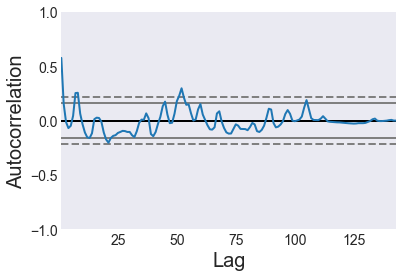

In [3]:
week_by_dept = get_week_by_dept_df()
pd.tools.plotting.autocorrelation_plot(week_by_dept.iloc[:, 0])
plt.show()

<Figure size 432x288 with 0 Axes>

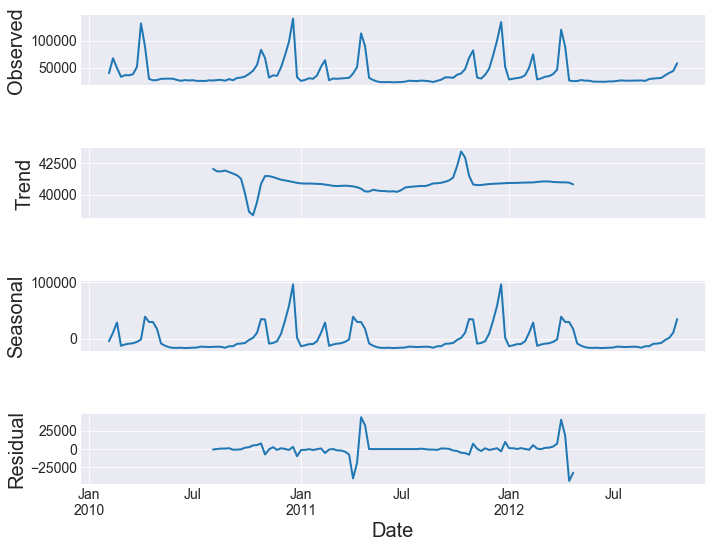

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
one_dept = week_by_dept.iloc[:, 0]
decomposition = seasonal_decompose(one_dept, freq=52)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(10, 8)
plt.tight_layout()

In [5]:
# from http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52).mean()
    rolstd = timeseries.rolling(window=52).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

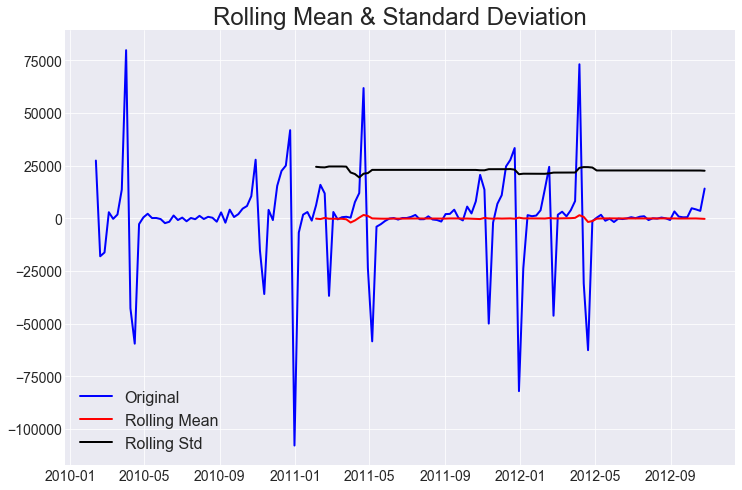

Results of Dickey-Fuller Test:
Test Statistic                -9.935376e+00
p-value                        2.752621e-17
#Lags Used                     5.000000e+00
Number of Observations Used    1.360000e+02
Critical Value (1%)           -3.479372e+00
Critical Value (5%)           -2.883037e+00
Critical Value (10%)          -2.578234e+00
dtype: float64


In [6]:
first_difference = one_dept - one_dept.shift(1)
test_stationarity(first_difference.dropna())

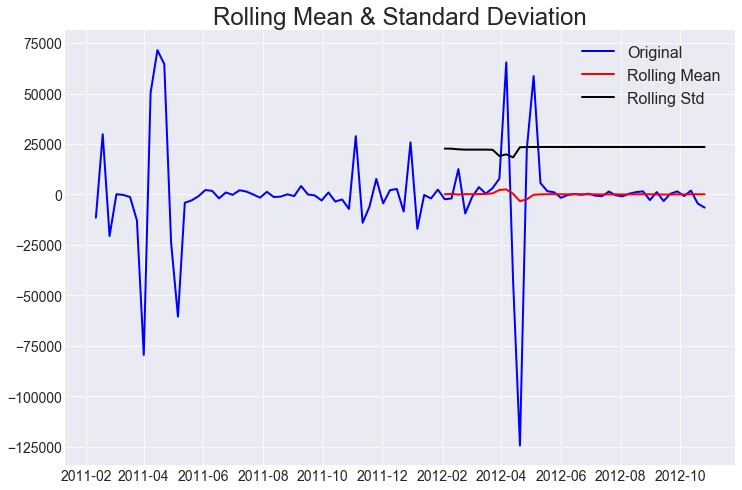

Results of Dickey-Fuller Test:
Test Statistic                -7.408643e+00
p-value                        7.231821e-11
#Lags Used                     5.000000e+00
Number of Observations Used    8.400000e+01
Critical Value (1%)           -3.510712e+00
Critical Value (5%)           -2.896616e+00
Critical Value (10%)          -2.585482e+00
dtype: float64


In [7]:
seasonal_first_difference = first_difference - first_difference.shift(52)
test_stationarity(seasonal_first_difference.dropna())

In [8]:
result = seasonal_decompose(week_by_dept, freq=52)

In [9]:
result.seasonal.head()

Store_Dept          10_1        10_10        10_11        10_12        10_13  \
Date                                                                           
2010-02-05  -4638.774405 -5282.793141 -1045.830848  -665.875286  2099.679303   
2010-02-12  10350.377759  1122.686138 -2859.289406   360.722791  3423.050553   
2010-02-19  28561.039442  4175.101186 -3678.018829   367.117743  2363.482620   
2010-02-26 -12898.295270  3316.950705 -2220.319454  1463.648753  6370.807091   
2010-03-05 -10462.194357  2156.860561 -2504.436809   516.946589  5701.137813   

Store_Dept        10_14        10_16        10_17         10_18       10_19  \
Date                                                                          
2010-02-05  1306.153390 -4653.014951  1858.617990 -10962.490267 -138.857457   
2010-02-12  4832.977910 -3540.186105  5588.418134   -381.812126  -85.900005   
2010-02-19  3526.099448  -534.503605  3721.444865  11974.978618 -643.305485   
2010-02-26  2831.826852   458.923847  5680.597317 -14533.328035  225.617303   
2010-03-05  5147.023967  1906.146732  3885.198615 -15000.799941    5.797351   

Store_Dept    ...             9_9        9_90        9_91         9_92  \
Date          ...                                                        
2010-02-05    ...    -4394.082526  -43.306805 -287.969332    65.049265   
2010-02-12    ...    -5457.652574 -149.227766 -524.230293   557.162775   
2010-02-19    ...    -1821.945507 -136.970555 -341.674428 -1104.183043   
2010-02-26    ...    -1918.769737  -29.836516 -240.778370 -1529.153043   
2010-03-05    ...     -679.729786  -27.158728  -96.419380  -911.352947   

Store_Dept      9_93         9_94         9_95        9_96      9_97      9_98  
Date                                                                            
2010-02-05 -0.161657  -216.406235 -2978.636359   86.786255  3.306741 -4.727764  
2010-02-12 -0.161657  1043.236754 -4420.385926 -617.088024  3.201768 -4.552284  
2010-02-19 -0.161657  3204.439871 -4584.834388 -791.206005  3.082799 -4.376803  
2010-02-26 -0.161657  1351.532299 -5352.432657 -974.690572  2.949833 -4.201322  
2010-03-05 -0.161657  1043.607371 -2865.399869 -942.130332  2.802871 -4.025841  

[5 rows x 3331 columns]

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
df_pred = pd.DataFrame(index=week_by_dept.index[104:])
for c in week_by_dept.columns[:2]:
    model = SARIMAX(week_by_dept[c].iloc[:104], trend='n', order=(0,1,0),
                    seasonal_order=(0,1,0,52))
    results = model.fit()
    y_pred = results.predict(start=104, end=len(week_by_dept), dynamic= True) 
    df_pred[c] = y_pred

/Users/benlindsay/miniconda/envs/walmart/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/Users/benlindsay/miniconda/envs/walmart/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/Users/benlindsay/miniconda/envs/walmart/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)


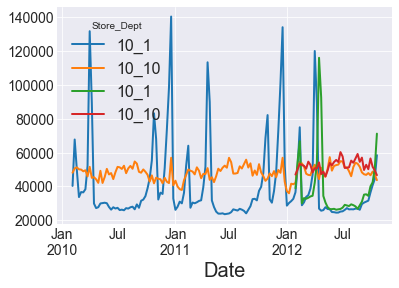

In [11]:
fig, ax = plt.subplots()
week_by_dept.iloc[:, :2].plot(ax=ax)
df_pred.plot(ax=ax)

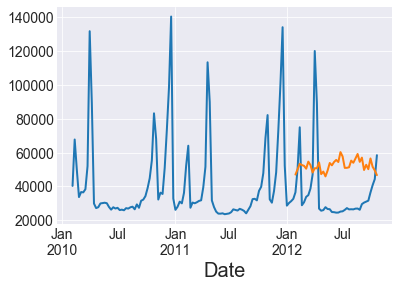

In [12]:
fig, ax = plt.subplots()
y_pred = pd.Series(y_pred, index=one_dept.index[104:])
one_dept.plot(ax=ax)
y_pred.plot(ax=ax)

In [13]:
from statsmodels.tsa.arima_model import ARIMA
X = week_by_dept.iloc[:, 0]
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
model = ARIMA(train, order=(0,1,0))
model_fit = model.fit(disp=0)
output = model_fit.forecast(steps=len(test))
predictions = output[0]

/Users/benlindsay/miniconda/envs/walmart/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/Users/benlindsay/miniconda/envs/walmart/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  % freq, ValueWarning)
/Users/benlindsay/miniconda/envs/walmart/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/benlindsay/miniconda/envs/walmart/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for 

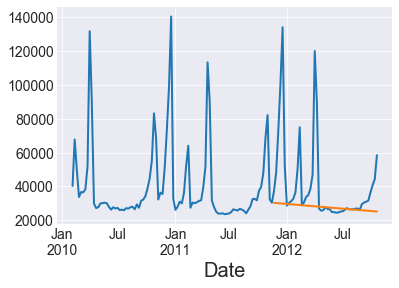

In [14]:
fig, ax = plt.subplots()
X.plot(ax=ax)
y_pred = pd.Series(predictions, index=test.index)
y_pred.plot(ax=ax)

In [15]:
from statsmodels.tsa.arima_model import ARIMA
X = week_by_dept.iloc[:, 0]
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

/Users/benlindsay/miniconda/envs/walmart/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/benlindsay/miniconda/envs/walmart/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/benlindsay/miniconda/envs/walmart/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(s

predicted=30167.706882, expected=37228.540000
predicted=37196.792128, expected=48269.300000
predicted=48354.104842, expected=72970.200000
predicted=73311.422500, expected=100775.800000
predicted=101400.160412, expected=134217.740000
predicted=135176.973673, expected=52228.860000
predicted=52350.233939, expected=28520.490000
predicted=28403.566500, expected=30107.310000
predicted=30007.255248, expected=31180.230000
predicted=31091.675000, expected=32559.130000
predicted=32484.822136, expected=36444.000000
predicted=36407.761154, expected=50434.110000
predicted=50531.455429, expected=74930.330000
predicted=75257.853491, expected=28751.570000
predicted=28644.455327, expected=30525.880000
predicted=30436.185926, expected=33728.460000
predicted=33668.970275, expected=34745.100000
predicted=34695.393273, expected=38656.880000
predicted=38642.862341, expected=46922.970000
predicted=46982.881875, expected=120131.350000
predicted=120838.593451, expected=89291.510000
predicted=89722.024649, expe

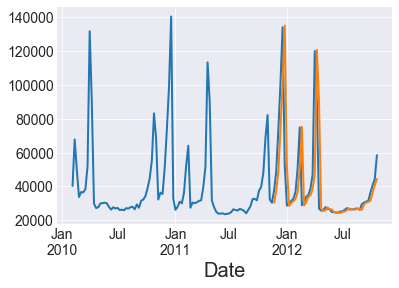

In [16]:
fig, ax = plt.subplots()
X.plot(ax=ax)
y_pred = pd.Series(predictions, index=test.index)
y_pred.plot(ax=ax)

In [17]:
# df = pd.DataFrame({'pred': predictions, 'actual': history}, index=test.index)
# df.plot(ax=ax)
plt.show()